In [1]:
import pickle
import os
import sys

In [2]:
from collections import defaultdict
from utils.dict_utils import dict_to_defaultdict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
dataset = 'mnist'
train_size = 1000
num_hidden = 1
bias = False
normalization = 'none'
optimizer = 'sgd'
num_seeds = 5
base_lr = 0.1

In [64]:
log_dir = os.path.join(
    'results', 'lr_dependence', '{}_{}'.format(dataset, train_size), 
    'num_hidden={}_bias={}_normalization={}'.format(num_hidden, bias, normalization), '{}_lr={}'.format(optimizer, base_lr))
log_dir

'results/lr_dependence/mnist_1000/num_hidden=1_bias=False_normalization=none/sgd_lr=0.1'

In [65]:
results_all_path = os.path.join(log_dir, 'results_all.dat')
results_all = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))))))
if os.path.exists(results_all_path):
    with open(results_all_path, 'rb') as f:
        results_all = dict_to_defaultdict(pickle.load(f), results_all)

In [66]:
scaling_modes = ['default', 'mean_field', 'ntk', 'mean_field_init_corrected', 'intermediate_q=0.75']
ref_widths = [32, 512]
correction_epochs = [0]
width_factors = [1, 16]
log10_lr_factors = [-2, -1.5, -1, -0.5, 0., 0.5, 1]

In [55]:
plt.rcParams.update({'font.size': 14})

In [56]:
def draw_curve(scaling_mode, ref_width, correction_epoch, width_factor, key, **kwargs):
    data = [
        [
            results_all[scaling_mode][ref_width][correction_epoch][width_factor][log10_lr_factor][seed][key] 
            for log10_lr_factor in log10_lr_factors
        ] for seed in range(num_seeds)
    ]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(log10_lr_factors, data_mean, **kwargs)
    plt.fill_between(
        log10_lr_factors,
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

In [57]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
cmap = plt.get_cmap('tab10')
keys = ['final_test_loss', 'final_test_acc', 'final_train_loss', 'final_train_acc']
ylims = [(0.2,1.6), (0.75, 0.95), (0.0,1.6), None]

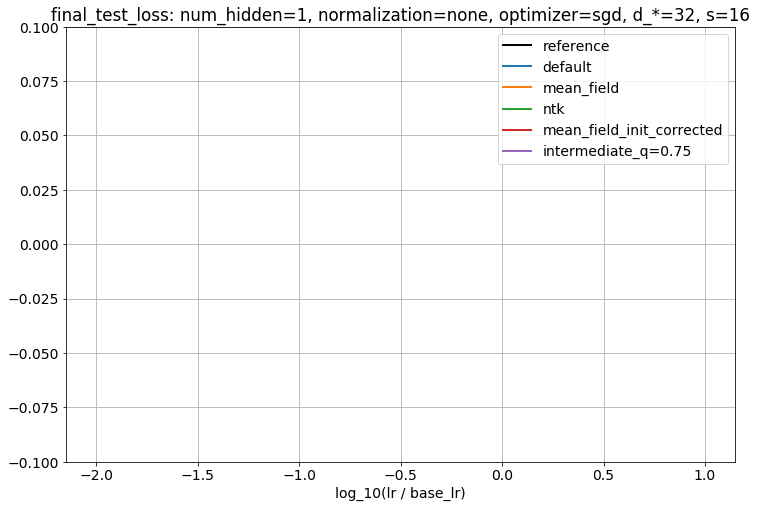

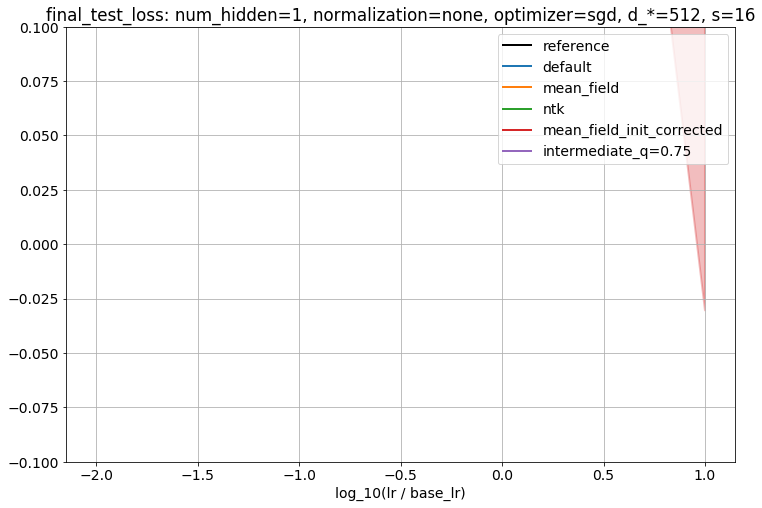

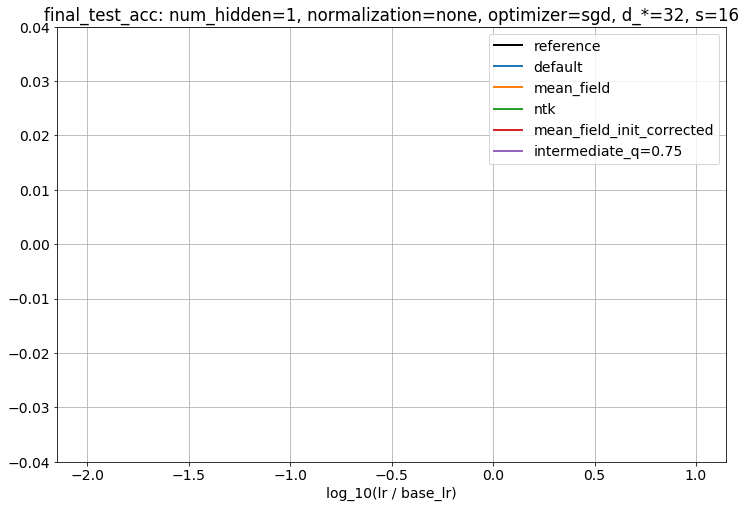

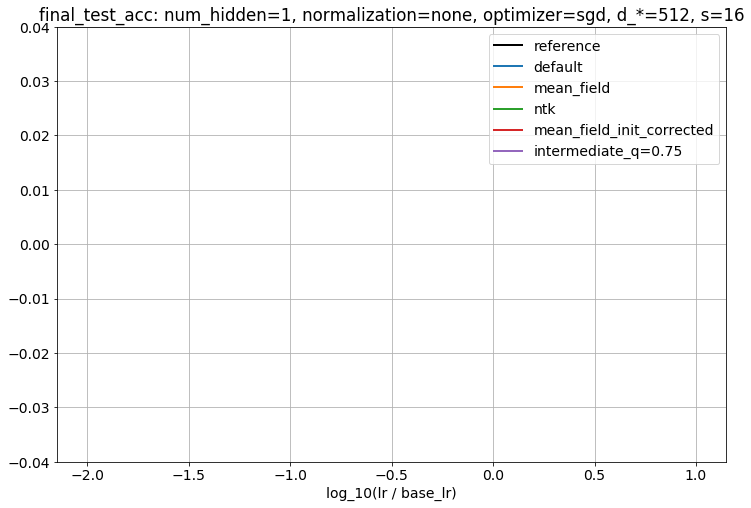

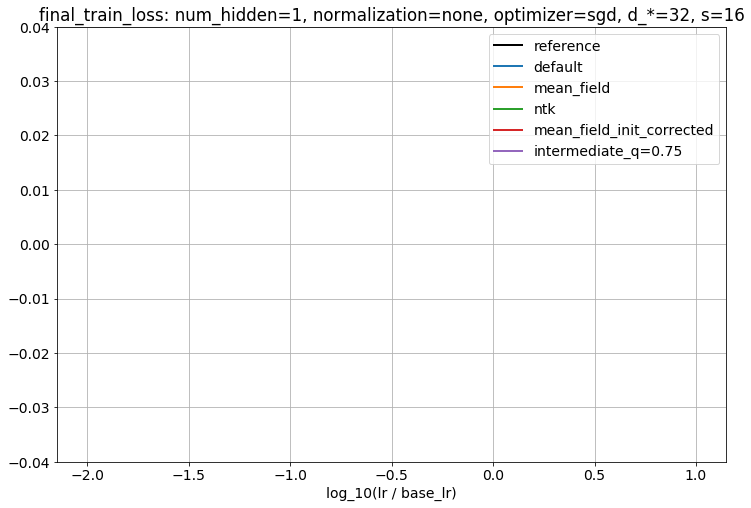

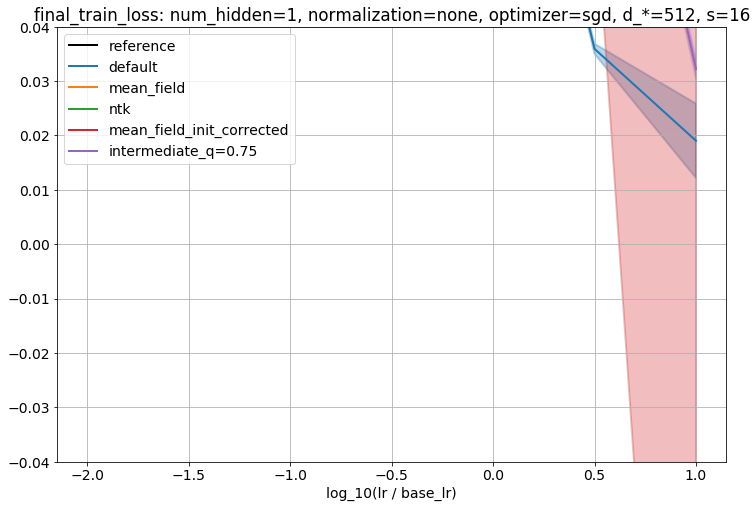

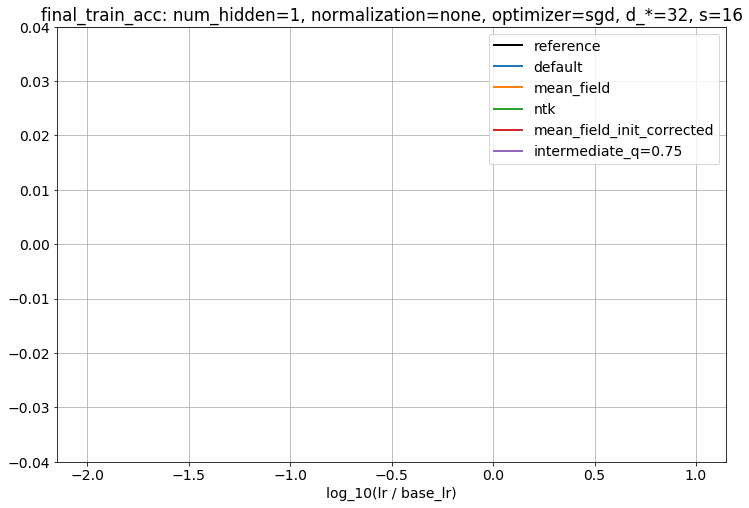

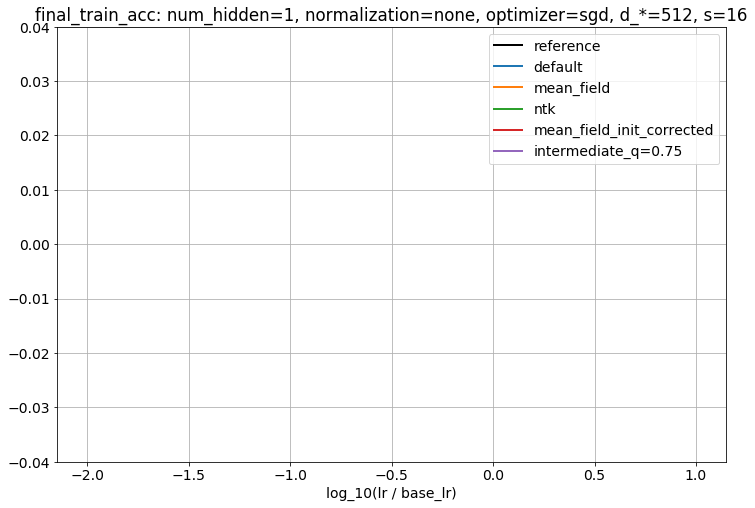

In [67]:
for key, ylim in zip(keys, ylims):
    for i, ref_width in enumerate(ref_widths):
        for width_factor in width_factors[1:]:
            _ = plt.figure(figsize=(12,8))

            plt.title(
                '{}: num_hidden={}, normalization={}, optimizer={}, d_*={}, s={}'.format(
                    key, num_hidden, normalization, optimizer, ref_width, width_factor
                )
            )

            plt.xlabel("log_10(lr / base_lr)")
            plt.ylim(ylim)
            plt.grid(True)

            for k, scaling_mode in enumerate(scaling_modes):
                for j, correction_epoch in enumerate(
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    if scaling_mode == 'default':
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, 1, key, 
                            color='black', linewidth=2
                        )
                    draw_curve(
                        scaling_mode, ref_width, correction_epoch, width_factor, key, 
                        color=cmap(k), linewidth=2+j
                    )

            plt.legend(
                ['reference'] + [
                    '{}'.format(scaling_mode) 
                    for scaling_mode in scaling_modes
                ]
            )
            plt.show()

In [68]:
def draw_relative_curve(scaling_mode, ref_width, correction_epoch, width_factor, 
                        key, **kwargs):
    data_base = [
        [
            results_all['default'][ref_width][None][1][log10_lr_factor][seed][key] 
            for log10_lr_factor in log10_lr_factors
        ] for seed in range(num_seeds)
    ]
    data_base = np.array(data_base)
    data = [
        [
            results_all[scaling_mode][ref_width][correction_epoch][width_factor][log10_lr_factor][seed][key] 
            for log10_lr_factor in log10_lr_factors
        ] for seed in range(num_seeds)
    ]
    data = np.array(data)
    data_rel = data - data_base
    data_rel_mean = data_rel.mean(axis=0)
    data_rel_std = data_rel.std(axis=0)
    plt.plot(log10_lr_factors, data_rel_mean, **kwargs)
    plt.fill_between(
        log10_lr_factors,
        data_rel_mean - data_rel_std, data_rel_mean + data_rel_std,
        alpha=0.3, **kwargs
    )

In [73]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
cmap = plt.get_cmap('tab10')
keys = ['final_test_loss', 'final_test_acc', 'final_train_loss', 'final_train_acc']
ylims = [(-0.2,0.2)] * len(keys)

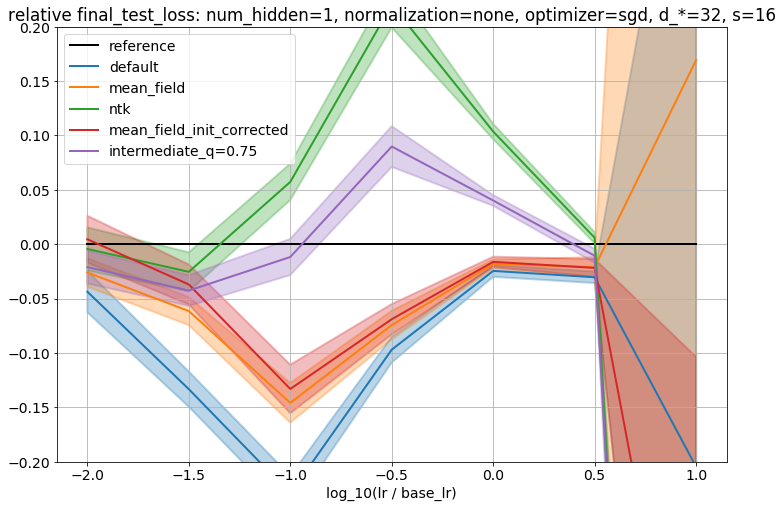

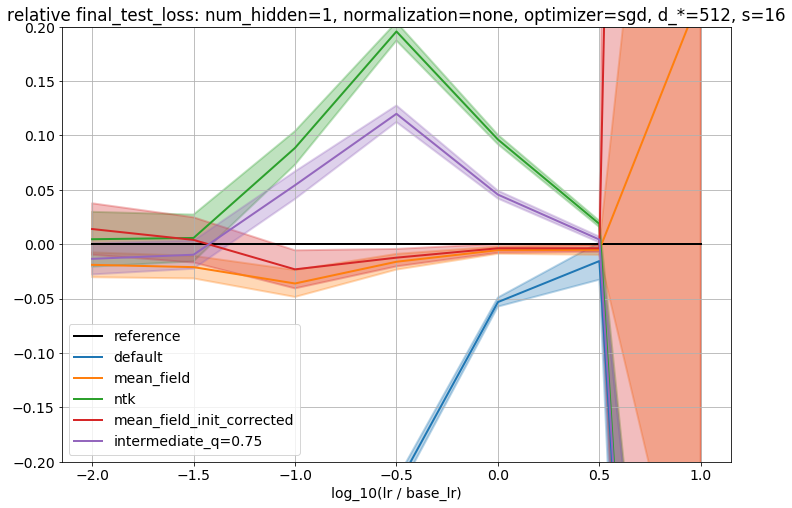

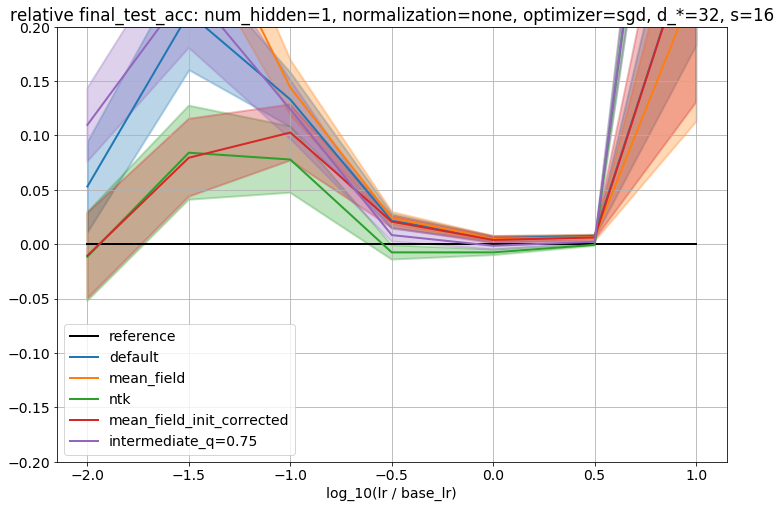

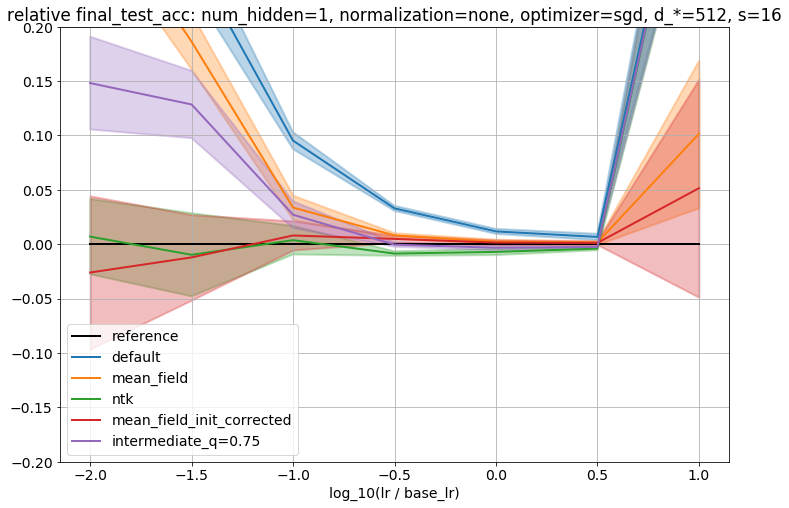

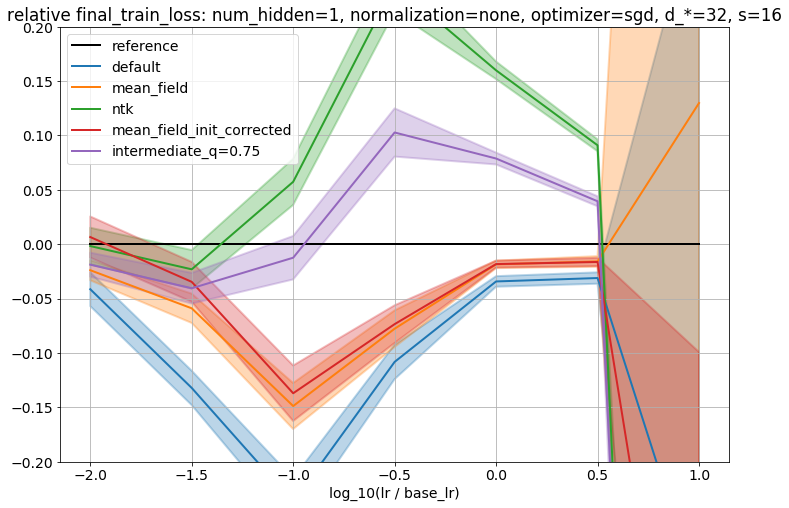

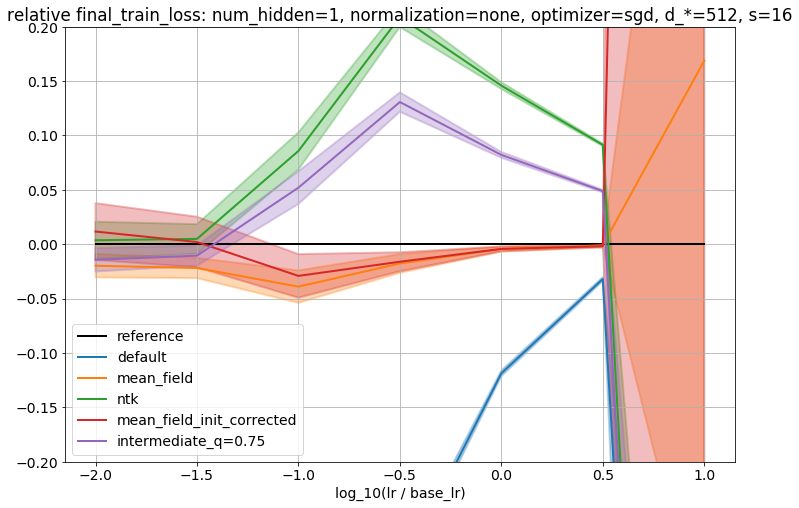

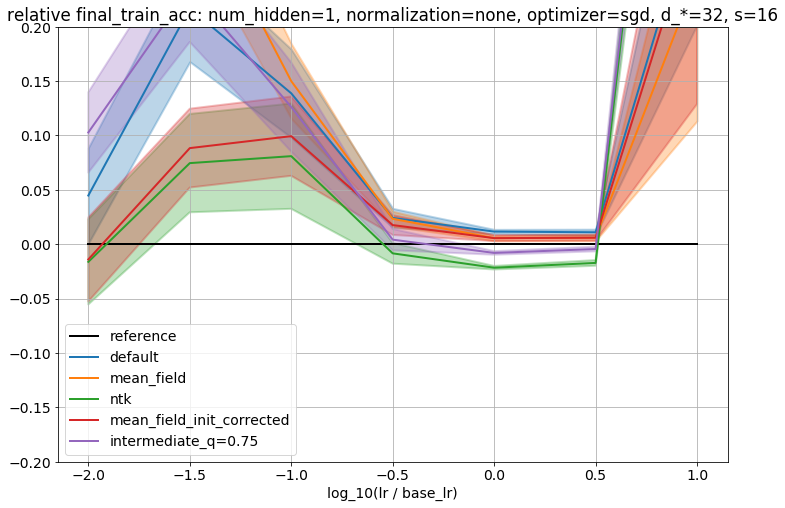

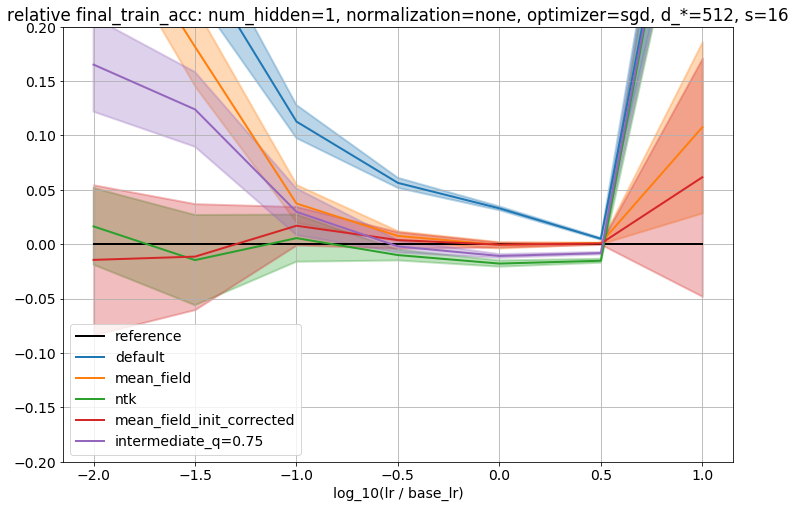

In [74]:
for key, ylim in zip(keys, ylims):
    for i, ref_width in enumerate(ref_widths):
        for width_factor in width_factors[1:]:
            _ = plt.figure(figsize=(12,8))

            plt.title(
                'relative {}: num_hidden={}, normalization={}, optimizer={}, d_*={}, s={}'.format(
                    key, num_hidden, normalization, optimizer, ref_width, width_factor
                )
            )

            plt.xlabel("log_10(lr / base_lr)")
            plt.ylim(ylim)
            plt.grid(True)

            for k, scaling_mode in enumerate(scaling_modes):
                for j, correction_epoch in enumerate(
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    if scaling_mode == 'default':
                        draw_relative_curve(
                            scaling_mode, ref_width, correction_epoch, 1, key, 
                            color='black', linewidth=2
                        )
                    draw_relative_curve(
                        scaling_mode, ref_width, correction_epoch, width_factor, key, 
                        color=cmap(k), linewidth=2+j
                    )

            plt.legend(
                ['reference'] + [
                    '{}'.format(scaling_mode) 
                    for scaling_mode in scaling_modes
                ]
            )
            plt.show()